# Machine Learning - Project 2:
# _Autoencoder for mathematical modeling of blood flow in a stenosis context_

## Context

In this project, we are going to analyze data derived from...

Our goals:
1. modeliser mathématiquement l’écoulement sanguin à l’aide de PDE dépendante de 2-3 paramètres physique
2. simuler l’écoulement par un code d’éléments fini ou similaire
3. générer beaucoup de solutions avec une grande nombre de paramètres différents. (Les 2-3, pris de façon aléatoire)
4. a. utiliser les solutions numérique pour établir un auto encoder qui au milieu n’ai que 2-5 hyper-paramètres libres  
b. quel erreur on obtient ? Est-ce possible de réduire le nombre d’hyper-paramètres ?
5. étudier s’il y a une rélation entre les 2-5 hyper-paramètre et les paramètres physique  
a. à l’aide de statistiques
5. b. à l’aide d’un DNN (différent de 4a)
6. (optionnel) faire un DNN entre l’input de 4a et output les paramêtres physique. Et/ou l’inverse.
7. Discussion et conclusions 

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Pickle](#pickle)

[4. Autoencoder](#autoencoder)

### Imports  <a name="1imports"></a>

In [177]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from autoencoder_Copy1 import *
from crossvalidation import *
import _pickle as cPickle
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)
np.random.seed(1)
seed = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data exploration  <a name="data_exploration"></a>

### Pathways <a name="1pathways"></a>

In [71]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_very_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_very_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [72]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [73]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (137725, 110)
Our input array Uy is of shape: (137725, 110)
Printing a row of Ux: 
 [0.0694243  0.27537487 0.60389834 1.02538242 1.49979277 1.9813229
 2.42318455 2.78232553 3.02371067 3.12378595 3.22605803 3.32166836
 3.41249686 3.49946177 3.58301614 3.66339786 3.74073801 3.81511138
 3.88656184 3.95511576 4.02078945 4.08359325 4.14353388 4.20061589
 4.2548424  4.30621561 4.35473712 4.40040807 4.44322934 4.48320158
 4.52032526 4.55460075 4.58602833 4.61460821 4.64034055 4.66322547
 4.68326307 4.70045341 4.71479655 4.72629252 4.73494137 4.7407431
 4.74369775 4.74423086 4.74375285 4.74246986 4.74042825 4.73764939
 4.73414407 4.72991811 4.7249748  4.71931611 4.71294324 4.70585693
 4.6980577  4.68954587 4.68032167 4.67038525 4.65973675 4.64837623
 4.63630377 4.6235194  4.61002317 4.5958151  4.5808952  4.5652635
 4.54892001 4.53186473 4.51409767 4.49561883 4.47642823 4.45652585
 4.43591171 4.41458581 4.39254814 4.36979872 4.34633752 4.32216457
 4.29727986 4.27

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [74]:
positions =5509 #We know it from the matlab code
times = Ux.shape[1]
simulations = int(Ux.shape[0]/positions)
print("We ran ", simulations, "simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)")
print("1 simulation calculate the velocities of the blood flow at ", positions, " different positions and at ", times, " different times")

We ran  25 simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)
1 simulation calculate the velocities of the blood flow at  5509  different positions and at  110  different times


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [75]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

ADDITIONAL IDEAS FOR PREPROCESSING
- remove columns with 0 std dev?
- standardization?

Let's sample our data points into the following ratios : 

In [76]:
ratio_pts = 0.1
ratio_time = 0.5

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(13750, 55) (13750, 55)


In [77]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from ', 5509, ' positions to ', new_Nu, ' positions')
print('With the sampling we got from ', 110, ' time steps to ', new_Nt, ' time steps')

With the sampling we got from  5509  positions to  550  positions
With the sampling we got from  110  time steps to  55  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery :

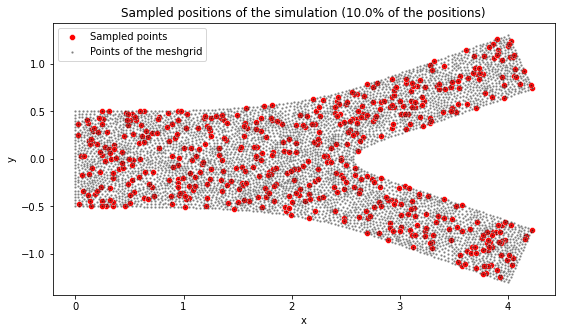

In [78]:
plot_sampled_coord(new_inds) 

In [79]:
print(new_Ux)

[[0.05835955 0.49017009 1.1771073  ... 2.3972929  2.33386954 2.26842866]
 [0.01521457 0.10728349 0.22658085 ... 0.34120634 0.33186228 0.32222659]
 [0.05227898 0.43588769 1.03893716 ... 2.03544675 1.98129714 1.92543036]
 ...
 [0.08793295 0.77062365 1.91659264 ... 4.29471327 4.18221467 4.06611756]
 [0.04154516 0.28052928 0.56214566 ... 0.6288614  0.61074307 0.59207462]
 [0.05565444 0.41835948 0.93252481 ... 1.679056   1.63414775 1.58781946]]


Let's flatten our matrices into a single matrix with dimensions $(N_s, (2 N_u N_t))$. For each simulation, the x and y speed coordinates are compressed to the following 1D matrix:

$$
\mathbf{M_{1D}}
=
\begin{bmatrix}
\vdots \\
u_{x}^{(0)} \\
\vdots \\
u_{y}^{(0)} \\
\vdots \\
u_{x}^{(1)} \\
\vdots \\
u_{y}^{(1)} \\
\vdots \\
u_{x}^{(N_t - 1)} \\
\vdots \\
u_{y}^{(N_t - 1)} \\
\vdots 
\end{bmatrix}
$$



In [80]:
flattened_array = flatten(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 60500)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u}}$.

In [81]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

60500


## 3. Pickle  <a name="pickle"></a>

To avoid the loading and processing steps each time we open the notebook, we will save the processed matrix "flattened_array" using pickle : 

In the following cell, we will create pickles for every subsampled data according to the ratios_pts and the ratios_t :

In [14]:
'''
ratios_pts = [0.1, 0.05, 0.02]
ratios_t = [0.5, 0.25, 0.1]

create_subsamples(Ux, Uy, ratios_pts, ratios_t, name_file='middle_small')
'''

#### Start from here if you the pickle file already exist in your data folder

Change only the following cell to change the name of the file you want to open :

In [172]:
ratios = [0.1, 0.5]
size = ['very_small', 'middle_small', 'small']

name = 'processed_'+str(size[1])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file you want to read : ', name)

name of the file you want to read :  processed_middle_small_0.1_0.5


In [173]:
flattened_array  = cPickle.load(open("data/pickle/"+str(size[1])+"/"+name, "rb"))

In [174]:
print(flattened_array)

[[ 6.59818698e-02  1.82234920e-02  6.44159502e-02 ...  1.03034493e+00
  -9.73947264e-03 -1.67477632e-02]
 [ 5.29771523e-02  1.32216300e-02  4.90189335e-02 ...  9.93200215e-01
   5.02639122e-03  1.41599883e-03]
 [ 8.25671280e-02  2.32952726e-02  6.87771891e-02 ...  1.77500861e+00
   3.44533164e-04  1.81417079e-02]
 ...
 [ 2.19606656e-01  2.55903473e-02  2.29397872e-01 ...  1.46759534e+00
   7.42708226e-02 -1.34336791e-02]
 [ 2.41341112e-01  5.06083120e-02  2.15209040e-01 ...  4.44840207e+00
   4.35858394e-02  2.36892166e-02]
 [ 6.98710694e-02  1.96083000e-02  6.43463295e-02 ...  1.38366628e+00
  -1.23426650e-03  1.73919218e-03]]


In [175]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(scaler.fit(flattened_array))
flattened_array = scaler.transform(flattened_array)
print(flattened_array)

MinMaxScaler()
[[3.95305438e-02 1.31789068e-01 5.28455226e-02 ... 9.13578870e-03
  2.16850505e-01 6.22175647e-01]
 [0.00000000e+00 7.58287403e-02 2.98163350e-04 ... 4.68536465e-03
  2.95927018e-01 7.33860285e-01]
 [8.99448862e-02 1.88531639e-01 6.77296782e-02 ... 9.83562698e-02
  2.70853984e-01 8.36702678e-01]
 ...
 [5.06505038e-01 2.14208702e-01 6.15900335e-01 ... 6.15241262e-02
  6.66755862e-01 6.42553159e-01]
 [5.72571438e-01 4.94107169e-01 5.67476304e-01 ... 4.18663887e-01
  5.02426736e-01 8.70812985e-01]
 [5.13525752e-02 1.47282161e-01 5.26079192e-02 ... 5.14683226e-02
  2.62398944e-01 7.35847524e-01]]


##### Final step : split train/test

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [200]:
x_train, x_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = x_train, x_test

print(x_train.shape)
print(x_test.shape)

(157, 60500)
(18, 60500)


In [201]:
x_train.min()

0.0

## 4. Feed-forward auto-encoder  <a name="autoencoder"></a>

In [205]:
learningRate = 1e-4
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
criterion = nn.MSELoss()  
dataset_name = "middle_small" #Only used to save the plot with the good name
Kfold(x_train, k_folds, input_size, epochs, criterion, learningRate, neuron=5, momentum=0.9, comment = True)

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:0.908 Test Error:0.894
Epoch:2/50 Training Error:0.885 Test Error:0.870
Epoch:3/50 Training Error:0.860 Test Error:0.842
Epoch:4/50 Training Error:0.841 Test Error:0.820
Epoch:5/50 Training Error:0.830 Test Error:0.808
Epoch:6/50 Training Error:0.825 Test Error:0.802
Epoch:7/50 Training Error:0.823 Test Error:0.799
Epoch:8/50 Training Error:0.821 Test Error:0.798
Epoch:9/50 Training Error:0.821 Test Error:0.797
Epoch:10/50 Training Error:0.820 Test Error:0.797
Epoch:11/50 Training Error:0.820 Test Error:0.796
Epoch:12/50 Training Error:0.820 Test Error:0.796
Epoch:13/50 Training Error:0.820 Test Error:0.796
Epoch:14/50 Training Error:0.819 Test Error:0.796
Epoch:15/50 Training Error:0.819 Test Error:0.796
Epoch:16/50 Training Error:0.819 Test Error:0.795
Epoch:17/50 Training Error:0.819 Test Error:0.795
Epoch:18/50 Training Error:0.819 Test Error:0.795
Epoch:19/50 Training Error:0.819 Tes

KeyboardInterrupt: 

#### Parameters tuning

Find the best learning rate of our model using cross-validation :

In [86]:
# define network parameters
learning_rates =[1e-2, 1e-3, 1e-4, 1e-5]
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Learning rate =  0.01

Performance of 5 fold cross validation: 
Average Training Error: 10512.464 	 Average Test Error: 10685.136
 
Learning rate =  0.001

Performance of 5 fold cross validation: 
Average Training Error: 0.392 	 Average Test Error: 0.380
 
Learning rate =  0.0001

Performance of 5 fold cross validation: 
Average Training Error: 0.389 	 Average Test Error: 0.380
 
Learning rate =  1e-05

Performance of 5 fold cross validation: 
Average Training Error: 0.948 	 Average Test Error: 0.947
 

Best learning rate is  0.0001  with a best error of :  0.3797835463868534



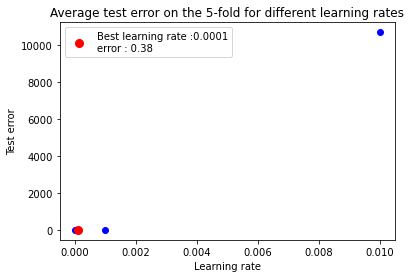

In [98]:
best_result, best_lr = tuning_lr(x_train, k_folds, input_size, epochs, criterion, learning_rates,  dataset_name_=dataset_name)

Find the best number of neurons in the latent space (neurons in the "middle layer of the auto-encoder") in the auto-encoder (which is actually the dimension of the compressed data) : 

In [99]:
# define network parameters
lr = best_lr # from above
epochs= 50
input_size=x_train.shape[1]
k_folds = 5
number_neurons = [3, 4, 5, 6, 7, 8, 9, 10]
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Number of neurons =  3

Performance of 5 fold cross validation: 
Average Training Error: 0.414 	 Average Test Error: 0.397
 
Number of neurons =  4

Performance of 5 fold cross validation: 
Average Training Error: 0.379 	 Average Test Error: 0.471
 
Number of neurons =  5

Performance of 5 fold cross validation: 
Average Training Error: 0.413 	 Average Test Error: 0.367
 
Number of neurons =  6

Performance of 5 fold cross validation: 
Average Training Error: 0.389 	 Average Test Error: 0.392
 
Number of neurons =  7

Performance of 5 fold cross validation: 
Average Training Error: 0.456 	 Average Test Error: 0.397
 
Number of neurons =  8

Performance of 5 fold cross validation: 
Average Training Error: 0.375 	 Average Test Error: 0.349
 
Number of neurons =  9

Performance of 5 fold cross validation: 
Average Training Error: 0.393 	 Average Test Error: 0.421
 
Number of neurons =  10

Performance of 5 fold cross validation: 
Average Training Error: 0.455 	 Average Test Error: 0.462
 

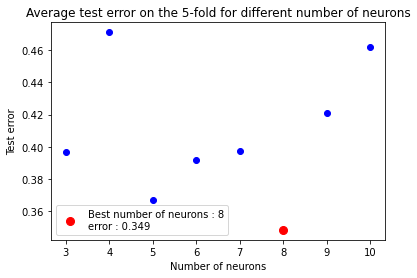

In [100]:
best_result, best_neurons_nb = tuning_latent_layer(x_train, k_folds, input_size, epochs, criterion, lr, number_neurons,  dataset_name_=dataset_name)

#### Let's try with the tuned parameters and see how it goes along the epochs

In [101]:
# define network parameters
learningRate= best_lr
epochs=50
input_size=x_train.shape[1]
k_folds = 3
neuron_ = best_neurons_nb

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:0.991 Test Error:0.990
Epoch:2/50 Training Error:0.939 Test Error:0.940
Epoch:3/50 Training Error:0.837 Test Error:0.840
Epoch:4/50 Training Error:0.697 Test Error:0.680
Epoch:5/50 Training Error:0.558 Test Error:0.529
Epoch:6/50 Training Error:0.390 Test Error:0.507
Epoch:7/50 Training Error:0.294 Test Error:0.366
Epoch:8/50 Training Error:0.340 Test Error:0.316
Epoch:9/50 Training Error:0.628 Test Error:0.433
Epoch:10/50 Training Error:0.428 Test Error:0.453
Epoch:11/50 Training Error:0.454 Test Error:0.391
Epoch:12/50 Training Error:0.539 Test Error:0.366
Epoch:13/50 Training Error:0.339 Test Error:0.345
Epoch:14/50 Training Error:0.393 Test Error:0.318
Epoch:15/50 Training Error:0.342 Test Error:0.463
Epoch:16/50 Training Error:0.338 Test Error:0.364
Epoch:17/50 Training Error:0.291 Test Error:0.387
Epoch:18/50 Training Error:0.453 Test Error:0.418
Epoch:19/50 Training Error:0.330 Tes

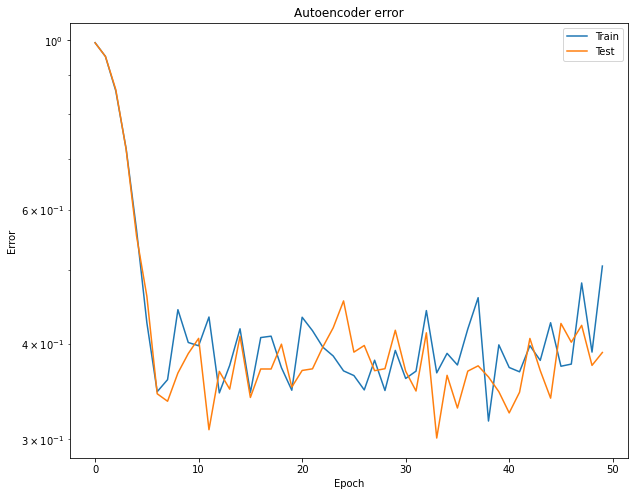

0.38999193462642817

In [102]:
Kfold(x_train, k_folds, input_size, epochs, criterion, learningRate, neuron=neuron_)

#### Quality of the compression on the test set using the tuned parameters :

We will now train and test our auto-encoder for different sample size of our initial dataset. To do so we will do a batch processing and store the final train and test errors. See the report to see the nice comparison table :

In [204]:
import glob
import os 
import _pickle as cPickle

dataset = 'middle_small'
file_location = os.path.join('data', 'pickle', dataset, '*')
filenames = glob.glob(file_location)
i=0 


# define the parameters of the model
learningRate= 1e-4
neuron_ = 8

epochs=50
criterion = nn.MSELoss() 

test_errors = []
train_errors = []
names = [] #Just to be sure of which error corresponds to which sub-dataset

for f in filenames:
    
    print("\033[1m" +'Train/Test of the sub-dataset ' + f + "\033[0m")
    
    #Load the data
    x  = cPickle.load(open(f, "rb"))
    
    #Split
    x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed)
    y_train, y_test = x_train, x_test
    
    #Declare the model
    input_size=x_train.shape[1]
    model = Autoencoder(input_size, neuron_)
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-5)
    
    #Dataloader
    train_loader = DataLoader(x_train, batch_size=20)
    test_loader = DataLoader(x_test, batch_size=20)
    
    #Training and testing over the epochs
    for epoch in range(epochs):
        # train the model 
        train_loss=train_epoch(train_loader, model, criterion, optimizer)
        # compute the relative training error
        train_error = valid_epoch(train_loader, model)
        # compute the relative test error
        test_error=valid_epoch(test_loader, model)
        
        print("Epoch:{}/{} Training Error:{:.3f} Test Error:{:.3f}".format(epoch + 1,epochs,train_error,test_error))
    
    #Save the last epoch train and test errors
    test_errors.append(test_error)
    train_errors.append(train_error)
    names.append(f)

Train/Test of the sub-dataset data/pickle/middle_small/processed_middle_small_0.02_0.5
Epoch:1/50 Training Error:0.969 Test Error:0.969
Epoch:2/50 Training Error:0.843 Test Error:0.842
Epoch:3/50 Training Error:0.630 Test Error:0.628
Epoch:4/50 Training Error:0.398 Test Error:0.398
Epoch:5/50 Training Error:0.225 Test Error:0.230
Epoch:6/50 Training Error:0.135 Test Error:0.154
Epoch:7/50 Training Error:0.106 Test Error:0.142
Epoch:8/50 Training Error:0.100 Test Error:0.139
Epoch:9/50 Training Error:0.099 Test Error:0.138
Epoch:10/50 Training Error:0.098 Test Error:0.137
Epoch:11/50 Training Error:0.098 Test Error:0.137
Epoch:12/50 Training Error:0.098 Test Error:0.137
Epoch:13/50 Training Error:0.098 Test Error:0.137
Epoch:14/50 Training Error:0.098 Test Error:0.137
Epoch:15/50 Training Error:0.098 Test Error:0.137
Epoch:16/50 Training Error:0.098 Test Error:0.136
Epoch:17/50 Training Error:0.097 Test Error:0.136
Epoch:18/50 Training Error:0.097 Test Error:0.136
Epoch:19/50 Training E

Epoch:8/50 Training Error:0.084 Test Error:0.113
Epoch:9/50 Training Error:0.081 Test Error:0.112
Epoch:10/50 Training Error:0.080 Test Error:0.112
Epoch:11/50 Training Error:0.080 Test Error:0.112
Epoch:12/50 Training Error:0.080 Test Error:0.111
Epoch:13/50 Training Error:0.080 Test Error:0.111
Epoch:14/50 Training Error:0.079 Test Error:0.111
Epoch:15/50 Training Error:0.079 Test Error:0.111
Epoch:16/50 Training Error:0.079 Test Error:0.111
Epoch:17/50 Training Error:0.079 Test Error:0.110
Epoch:18/50 Training Error:0.078 Test Error:0.110
Epoch:19/50 Training Error:0.078 Test Error:0.109
Epoch:20/50 Training Error:0.077 Test Error:0.108
Epoch:21/50 Training Error:0.076 Test Error:0.106
Epoch:22/50 Training Error:0.074 Test Error:0.104
Epoch:23/50 Training Error:0.071 Test Error:0.101
Epoch:24/50 Training Error:0.068 Test Error:0.096
Epoch:25/50 Training Error:0.064 Test Error:0.090
Epoch:26/50 Training Error:0.058 Test Error:0.082
Epoch:27/50 Training Error:0.051 Test Error:0.072
Ep

Epoch:17/50 Training Error:0.097 Test Error:0.136
Epoch:18/50 Training Error:0.097 Test Error:0.136
Epoch:19/50 Training Error:0.097 Test Error:0.135
Epoch:20/50 Training Error:0.096 Test Error:0.134
Epoch:21/50 Training Error:0.095 Test Error:0.133
Epoch:22/50 Training Error:0.093 Test Error:0.130
Epoch:23/50 Training Error:0.091 Test Error:0.127
Epoch:24/50 Training Error:0.088 Test Error:0.123
Epoch:25/50 Training Error:0.082 Test Error:0.116
Epoch:26/50 Training Error:0.075 Test Error:0.106
Epoch:27/50 Training Error:0.066 Test Error:0.093
Epoch:28/50 Training Error:0.055 Test Error:0.078
Epoch:29/50 Training Error:0.043 Test Error:0.062
Epoch:30/50 Training Error:0.033 Test Error:0.047
Epoch:31/50 Training Error:0.024 Test Error:0.034
Epoch:32/50 Training Error:0.017 Test Error:0.025
Epoch:33/50 Training Error:0.013 Test Error:0.019
Epoch:34/50 Training Error:0.011 Test Error:0.015
Epoch:35/50 Training Error:0.010 Test Error:0.014
Epoch:36/50 Training Error:0.009 Test Error:0.013


In [107]:
from pandas import *

#If you want to load the test and train errors from the saved pickles files, uncomment following lines :
'''
dataset = "middle_small"
train_errors  = cPickle.load(open("data/pickle/results/"+"train_errors_" + dataset, "rb"))
test_errors  = cPickle.load(open("data/pickle/results/"+"test_errors_" + dataset, "rb"))
'''

results = DataFrame({'' : ['50%', '25%', '10%'],
                   '10%' : test_errors[:3][::-1],
                   '5%' : test_errors[3:6][::-1],
                   '2%' : test_errors[6:9][::-1]})

results = results.set_index('')

display(results)
print("\033[1m" + 'Table of relative error depending on the sampling of the dataset' + "\033[0m")
print('x : sampling of times')
print('y : sampling of positions')

,10%,5%,2%
,,,
50%,0.007399,0.008211,0.007557
25%,0.006007,0.013739,0.008072
10%,0.008849,0.007709,0.007796


Table of relative error depending on the sampling of the dataset
x : sampling of times
y : sampling of positions


In [108]:
#Save in pickles
name = "train_errors_" + dataset
cPickle.dump( train_errors , open( name, "wb" ) )
name = "test_errors_" + dataset
cPickle.dump( test_errors , open( name, "wb" ) )

### Physical interpretation

In [145]:
import _pickle as cPickle

# define the parameters of the model
learningRate= 1e-4
neuron_ = 8
epochs=50
criterion = nn.MSELoss() 


#Load the data
x  = cPickle.load(open('data/pickle/middle_small/processed_middle_small_0.05_0.1', "rb"))

#Split
x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed, shuffle=False)
y_train, y_test = x_train, x_test

#Declare the model
input_size=x_train.shape[1]
model = Autoencoder(input_size, neuron_)
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=1e-5)

#Dataloader
train_loader = DataLoader(x_train, batch_size=20)
test_loader = DataLoader(x_test, batch_size=20)

#Training and testing over the epochs
for epoch in range(epochs):
    # train the model 
    train_loss=train_epoch(train_loader, model, criterion, optimizer)
    # compute the relative training error
    train_error = valid_epoch(train_loader, model)
    # compute the relative test error
    test_error=valid_epoch(test_loader, model)

    print("Epoch:{}/{} Training Error:{:.3f} Test Error:{:.3f}".format(epoch + 1,epochs,train_error,test_error))

#Look at the compression
compressed_X_train = []
for train in train_loader :
    train = train.float()
    compressed_x_train = model.forward(x=train, show_compression=True)
    compressed_X_train.append(compressed_x_train.detach().numpy())

compressed_X_test = []    
for test in test_loader :
    test = test.float()
    compressed_x_test = model.forward(x=test, show_compression=True)
    compressed_X_test.append(compressed_x_test.detach().numpy())    

Epoch:1/50 Training Error:0.983 Test Error:0.983
Epoch:2/50 Training Error:0.885 Test Error:0.885
Epoch:3/50 Training Error:0.684 Test Error:0.681
Epoch:4/50 Training Error:0.452 Test Error:0.448
Epoch:5/50 Training Error:0.260 Test Error:0.254
Epoch:6/50 Training Error:0.143 Test Error:0.132
Epoch:7/50 Training Error:0.101 Test Error:0.070
Epoch:8/50 Training Error:0.093 Test Error:0.061
Epoch:9/50 Training Error:0.091 Test Error:0.060
Epoch:10/50 Training Error:0.091 Test Error:0.060
Epoch:11/50 Training Error:0.090 Test Error:0.060
Epoch:12/50 Training Error:0.090 Test Error:0.060
Epoch:13/50 Training Error:0.090 Test Error:0.059
Epoch:14/50 Training Error:0.090 Test Error:0.059
Epoch:15/50 Training Error:0.090 Test Error:0.059
Epoch:16/50 Training Error:0.089 Test Error:0.059
Epoch:17/50 Training Error:0.089 Test Error:0.059
Epoch:18/50 Training Error:0.088 Test Error:0.058
Epoch:19/50 Training Error:0.087 Test Error:0.058
Epoch:20/50 Training Error:0.086 Test Error:0.057
Epoch:21/

In [148]:
compressed_X_train_ = np.concatenate(np.squeeze(np.array(compressed_X_train)))
compressed_X_test_ = (np.squeeze(np.array(compressed_X_test)))

In [149]:
print(compressed_X_train_.shape)
print(compressed_X_test_.shape)

(157, 8)
(18, 8)


In [150]:
exponents = np.arange(3) + 1

compressed_X_train_pol = []
for row in compressed_X_train_: 
    compressed_X_train_pol.append((row**exponents[:,None]).ravel())
    
compressed_X_test_pol = []
for row in compressed_X_test_: 
    compressed_X_test_pol.append((row**exponents[:,None]).ravel())    

compressed_X_test_pol    

[array([-2.51023197e+01,  1.36625576e+01, -1.80539352e+02,  1.33666626e+02,
         5.56064758e+01,  9.57128448e+01, -8.49383774e+01, -6.34556656e+01,
         6.30126455e+02,  1.86665480e+02,  3.25944578e+04,  1.78667669e+04,
         3.09208015e+03,  9.16094867e+03,  7.21452795e+03,  4.02662150e+03,
        -1.58176357e+04,  2.55032788e+03, -5.88458230e+06,  2.38819045e+06,
         1.71939680e+05,  8.76820459e+05, -6.12790298e+05, -2.55511947e+05]),
 array([-9.11531258e+00,  5.35936880e+00, -5.13885498e+01,  3.60444374e+01,
         1.48251200e+01,  2.17197590e+01, -1.83377914e+01, -1.46456566e+01,
         8.30889234e+01,  2.87228339e+01,  2.64078305e+03,  1.29920147e+03,
         2.19784182e+02,  4.71747930e+02,  3.36274595e+02,  2.14495257e+02,
        -7.57381508e+02,  1.53936260e+02, -1.35706011e+05,  4.68289860e+04,
         3.25832687e+03,  1.02462514e+04, -6.16653339e+03, -3.14142387e+03]),
 array([-5.22576809e+00,  2.00536418e+00, -3.89364357e+01,  2.92898998e+01,
        

In [151]:
compressed_Y_pd = pd.read_csv("Data/params_middle_small.csv.bz2", header=None)
compressed_Y = compressed_Y_pd.to_numpy()

In [152]:
compressed_Y.shape

(175, 5)

In [153]:
compressed_Y_train = compressed_Y[:-18,:]
print(compressed_Y_train.shape)
compressed_Y_test = compressed_Y[-19:-1,:]
print(compressed_Y_test.shape)

(157, 5)
(18, 5)


In [154]:
from sklearn.linear_model import LinearRegression
reg_pol = LinearRegression().fit(compressed_X_train_, compressed_Y_train)
train_score = (reg_pol.score(compressed_X_train_, compressed_Y_train))
test_score = (reg_pol.score(compressed_X_test_, compressed_Y_test))
#print(reg_pol.coef_)
#print(reg_pol.intercept_)
print('The train score is: ', train_score)
print('The test score is: ', test_score)

The train score is:  0.6837902284156756
The test score is:  -0.6437241890235734


In [114]:
from sklearn.linear_model import Ridge
ridge_pol = Ridge(alpha=1).fit(compressed_X_train_pol, compressed_Y_train)
train_score_ridge = (ridge_pol.score(compressed_X_train_pol, compressed_Y_train))
test_score_ridge = (ridge_pol.score(compressed_X_test_pol, compressed_Y_test))
#print(reg_pol.coef_)
#print(reg_pol.intercept_)
print('The train score is: ', train_score_ridge)
print('The test score is: ', test_score_ridge)

The train score is:  0.7224061023235515
The test score is:  -0.6586698262059498


In [118]:
from sklearn.linear_model import ElasticNet
regr = ElasticNet(random_state=0, alpha=1).fit(compressed_X_train, compressed_Y_train)
train_score_elast = (regr.score(compressed_X_train, compressed_Y_train))
test_score_elast = (regr.score(compressed_X_test, compressed_Y_test))
#print(reg_pol.coef_)
#print(reg_pol.intercept_)
print('The train score is: ', train_score_elast)
print('The test score is: ', test_score_elast)

The train score is:  0.29529503702783017
The test score is:  -0.29845577963584896


## 4. Passer en 2D 

Instead of flattenning our initial dataset into a colummn vector for each simulation, we split it into a 2D matrix for each simulation such as the following:

$$
\mathbf{M_{2D}}
=
\begin{bmatrix}
\vdots & \vdots & \vdots & \vdots \\
u_{x}^{(0)} & u_{x}^{(1)} & \cdots &
u_{x}^{(N_t - 1)} \\
\vdots & \vdots & \ddots & \vdots \\
u_{y}^{(0)} & u_{y}^{(1)} & \cdots &
u_{y}^{(N_t - 1)} \\
\vdots & \vdots & \vdots & \vdots
\end{bmatrix}
$$

In [16]:
flattened_array = flatten_2d(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 1100, 110)

## 5. Passer en 4D

In [11]:
flattened_array_4d = flatten_4d(new_Ux, new_Uy, ratio_pts)
flattened_array_4d.shape

IndexError: index 55 is out of bounds for axis 1 with size 55

In [ ]:
flattened_array_4d = normalize(flattened_array_4d)

In [ ]:
x_train, x_test = train_test_split(flattened_array_4d, test_size=0.1, random_state=seed)

In [ ]:
import h5py

In [ ]:
hf = h5py.File('trainset.h5', 'w')
hf.create_dataset('dataset_1', data=x_train)

In [ ]:
hf = h5py.File('testset.h5', 'w')
hf.create_dataset('dataset_1', data=x)

## 6. Discussion & conclusion